In [14]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [15]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [16]:
df = df_origin[df_origin.Site_Name=='Caesarea']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [17]:
# dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfWithoutLastYearVisits = df.drop('last_year_visitors',axis=1).dropna()
dfLastYearVisits = df.dropna()

In [18]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(433, 7)
(663, 6)


In [19]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [20]:
dfWithoutLastYearVisits.sort_values('Date')
X = dfWithoutLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfWithoutLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [42]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16,activation='relu',activity_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
model.add(Dense(1))
 

In [43]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsCeasareaWithoutLastYearVisits.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
409/424 [===========================>..] - ETA: 0s - loss: 1616206.3750 - mae: 1008.6154 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 2008997.00000, saving model to weightsCeasareaWithoutLastYearVisits.h5
424/424 [==============================] - 3s 4ms/step - loss: 1575510.5000 - mae: 993.6111 - accuracy: 0.0000e+00 - val_loss: 2008997.0000 - val_mae: 1184.8894 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
408/424 [===========================>..] - ETA: 0s - loss: 1423860.3750 - mae: 919.0564 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 2008997.00000 to 1593644.12500, saving model to weightsCeasareaWithoutLastYearVisits.h5
424/424 [==============================] - 1s 3ms/step - loss: 1404705.5000 - mae: 909.7262 - accuracy: 0.0000e+00 - val_loss: 1593644.1250 - val_mae: 1004.6501 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
423/424 [============================>.] - ETA: 0s - loss: 963033.8125 - mae: 665.5563 - accuracy: 0.00

In [44]:
model.load_weights('weightsCeasareaWithoutLastYearVisits.h5')

17/17 [==============================] - 0s 1ms/step

mae 419.99425722518055
rmse 628.9239793548378
std 774.4161430087249


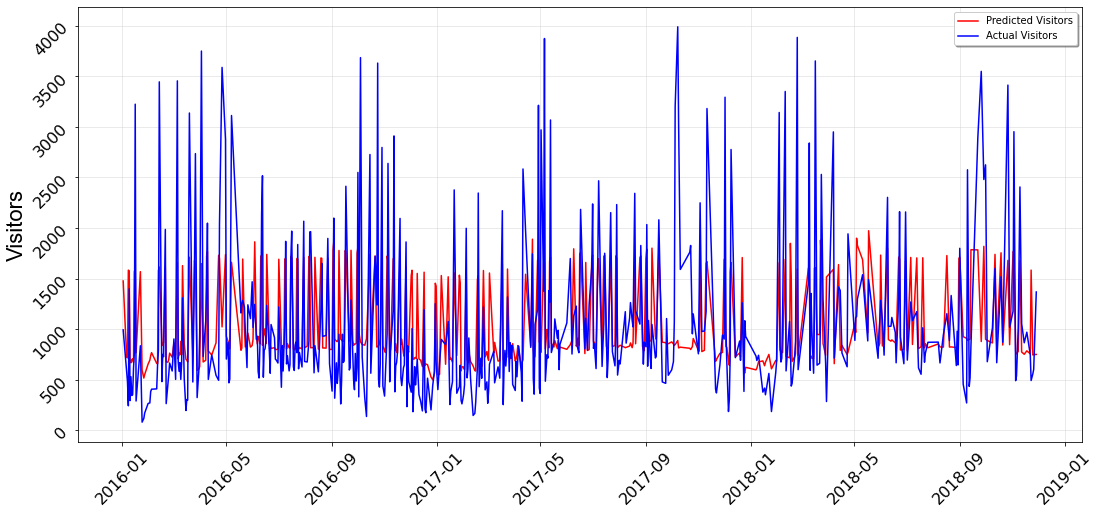

,Prediction,Actual
Date,,
2016-01-02,1475.852539,992
2016-01-06,723.162476,575
2016-01-07,715.527344,479
2016-01-08,1582.778564,241
2016-01-09,1576.009277,1398
2016-01-10,687.324524,292
2016-01-11,665.980591,528
2016-01-12,697.863892,343
2016-01-13,706.103149,351


In [45]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

5/5 [==============================] - 0s 1ms/step

mae 502.972493795524
rmse 726.496479524696
std 809.6101758828038


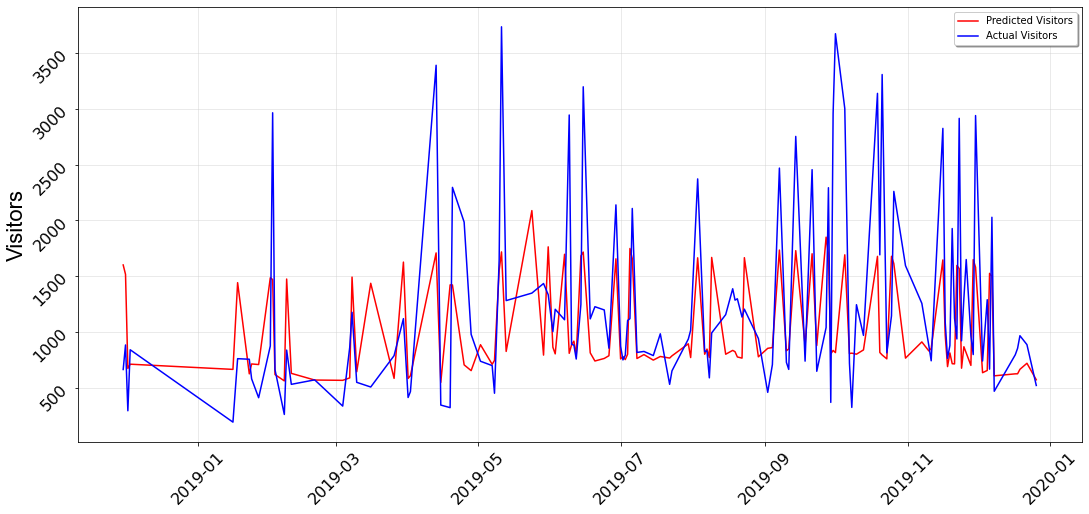

,Prediction,Actual
Date,,
2018-11-30,1599.488892,662
2018-12-01,1515.253784,882
2018-12-02,671.499512,292
2018-12-03,709.631287,839
2019-01-16,663.024353,190
2019-01-18,1440.591797,759
2019-01-23,622.957336,754
2019-01-24,711.701904,578
2019-01-27,706.401978,409


In [46]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [47]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(530, 4)
(2,)
(530, 4)
index  73 :: Actual values =  1154
index  73 :: Prediction values =  798.95751953125
157/157 [==============================] - 0s 1ms/step
Intercept 1684.8096846330068
Prediction_local [780.92792274]
Right: 798.9575


,0
is weekend,890.776435
IsVacation,-83.090821
Temperature,78.717273
pm10,-8.731778


In [48]:
function.getLimeAvg(X_test_scaled=X_test_scaled,X_train_scaled=X_train_scaled,X_train=X_train,model=model)